In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn import preprocessing
sns.set(rc={'figure.figsize':(18, 3)})

In [37]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data Collection

In [38]:
raw = pd.read_csv('cropMainData/ProductionCropsEAllDataNOFLAG.csv', encoding = "ISO-8859-1")
prices = pd.read_csv('prices/Prices_E_All_Data_NOFLAG.csv', encoding = "ISO-8859-1")
caffeinePrices = pd.read_csv('prices/caffeine-crop-prices.csv')
rainfall = pd.read_csv('climate/countries-rainfall-climate.csv')
temperatures = pd.read_csv('climate/countries-temperature-climate.csv')

## Data Preprocessing

In [39]:
# extract areas, items and elements and their respective codes into separate pds
areas = raw.set_index('Area Code')[['Area']].drop_duplicates()
items = raw.set_index('Item Code')[['Item']].drop_duplicates()
elements = raw.set_index('Element Code')[['Element']].drop_duplicates()

In [40]:
# basic cleaning of raw data
raw = raw.drop(['Area Code', 'Item Code', 'Element Code', 'Unit'], axis=1) # drop the codes and unit column
raw.fillna(0, inplace=True)
#remove Y from the year
raw.columns = [name[1:] if name[0] is 'Y' else name for name in raw.columns]
raw.head()

Area                              Item         Element    1961  \
0  Afghanistan               Almonds, with shell  Area harvested 0.00000   
1  Afghanistan               Almonds, with shell           Yield 0.00000   
2  Afghanistan               Almonds, with shell      Production 0.00000   
3  Afghanistan  Anise, badian, fennel, coriander  Area harvested 0.00000   
4  Afghanistan  Anise, badian, fennel, coriander           Yield 0.00000   

     1962    1963    1964    1965    1966    1967  ...        2009  \
0 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  ... 11029.00000   
1 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  ... 39154.00000   
2 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  ... 43183.00000   
3 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  ... 17748.00000   
4 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  ...  6203.00000   

         2010        2011        2012        2013        2014        2015  \
0 11210.00000 13469.00000 13490.00000 14114.00000 13703.00000 14676.00000   
1 49955.00000 45000.00000 45960.00000 29910.00000 19996.00000 16521.00000   
2 56000.00000 60611.00000 62000.00000 42215.00000 27400.00000 24246.00000   
3 17000.00000 19500.00000 18500.00000 18500.00000 30000.00000 25000.00000   
4  6000.00000  6414.00000  6757.00000  6757.00000  7167.00000  7200.00000   

         2016        2017        2018  
0 19481.00000 19793.00000 20053.00000  
1 16859.00000 13788.00000 17161.00000  
2 32843.00000 27291.00000 34413.00000  
3 25638.00000 27582.00000 25785.00000  
4  7037.00000  6954.00000  7036.00000  

[5 rows x 61 columns]

In [41]:
#resolve naming inconsistencies
raw.loc[raw.Area == "United Kingdom of Great Britain and Northern Ireland", "Area"] = "United Kingdom"
raw.loc[raw.Area == "United States of America", "Area"] = "United States"
raw.loc[raw.Area == "Russian Federation", "Area"] = "Russia"

In [42]:
raw.describe()

1961            1962            1963             1964  \
count     50251.00000     50251.00000     50251.00000      50251.00000   
mean     727782.09196    741732.47832    756092.66100     790072.71581   
std     9299648.48158   9420370.98091   9588692.69127   10194846.92951   
min           0.00000         0.00000         0.00000          0.00000   
25%           0.00000         0.00000         0.00000          0.00000   
50%        4488.00000      4668.00000      4766.00000       4928.00000   
75%       55505.50000     56407.00000     57924.50000      59266.00000   
max   876874886.00000 933373275.00000 949346114.00000 1001214296.00000   

                 1965             1966             1967             1968  \
count     50251.00000      50251.00000      50251.00000      50251.00000   
mean     799427.96551     822501.13253     845989.36871     857458.53326   
std    10344609.33070   10774892.62678   11055188.48710   11242379.47774   
min           0.00000          0.00000          0.00000          0.00000   
25%           0.00000          0.00000          0.00000          0.00000   
50%        4991.00000       5000.00000       5102.00000       5244.00000   
75%       59922.50000      60587.00000      62222.00000      62957.00000   
max   998593157.00000 1078340254.00000 1124081414.00000 1160679900.00000   

                  1969             1970  ...             2009  \
count      50251.00000      50251.00000  ...      50251.00000   
mean      862053.58275     896669.77413  ...    1857181.78904   
std     11281444.64139   11846430.81864  ...   25864844.35621   
min            0.00000          0.00000  ...          0.00000   
25%            0.00000          0.00000  ...       2015.50000   
50%         5225.00000       5418.00000  ...      21848.00000   
75%        63476.50000      64241.00000  ...     137282.50000   
max   1170999674.00000 1192508666.00000  ... 2491795662.00000   

                  2010             2011             2012             2013  \
count      50251.00000      50251.00000      50251.00000      50251.00000   
mean     1883542.88786    1975749.16764    1995235.01980    2076882.64643   
std     26106711.05757   27509262.15365   27680903.37443   29046111.05508   
min            0.00000          0.00000          0.00000          0.00000   
25%         2095.00000       2154.50000       2194.00000       2225.00000   
50%        22201.00000      22880.00000      22900.00000      23430.00000   
75%       138000.00000     141155.00000     142236.00000     144004.50000   
max   2467415058.00000 2588162195.00000 2564336618.00000 2769038293.00000   

                  2014             2015             2016             2017  \
count      50251.00000      50251.00000      50251.00000      50251.00000   
mean     2120320.02261    2126951.34065    2144437.74685    2187464.21586   
std     29346546.92114   29592579.21121   30058879.02848   30418506.08417   
min            0.00000          0.00000          0.00000          0.00000   
25%         2254.00000       2317.50000       2345.50000       2338.00000   
50%        23730.00000      24082.00000      24025.00000      24275.00000   
75%       146574.50000     148936.00000     148857.50000     150802.50000   
max   2820447235.00000 2849840878.00000 2938515394.00000 3020299421.00000   

                  2018  
count      50251.00000  
mean     2190507.09902  
std     30456575.09962  
min            0.00000  
25%         2358.50000  
50%        24333.00000  
75%       152844.00000  
max   2962867626.00000  

[8 rows x 58 columns]

In [43]:
# Cleaning prices dataset
prices.fillna(0, inplace=True)
prices.columns = [year[1:] if year[0] is 'Y' else year for year in prices.columns]
prices_melted = pd.melt(prices, id_vars=['Item'], value_vars=prices.columns[9:], value_name='Price')

In [44]:
caffeinePrices.fillna(0, inplace=True)
caffeinePrices = caffeinePrices[caffeinePrices['Unit']=='USD']
caffeinePrices.drop(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Year Code', 'Months Code', 'Months', 'Flag', 'Flag Description', 'Element', 'Unit'], axis=1, inplace=True)
caffeinePrices['Item'].value_counts()
caffeinePrices = caffeinePrices[np.logical_and(caffeinePrices['Item']!='Lettuce and chicory', caffeinePrices['Item']!='Tea nes')]
caffeinePrices.rename(columns={'Value':'Price'}, inplace=True)
caffeinePrices

Area  Item Code           Item  Year       Price
66       Angola        656  Coffee, green  2010   511.40000
67       Angola        656  Coffee, green  2011   702.60000
92    Argentina        667            Tea  1991    49.80000
93    Argentina        667            Tea  1992    50.50000
94    Argentina        667            Tea  1993    63.10000
...         ...        ...            ...   ...         ...
7077      Yemen        656  Coffee, green  2013  7957.90000
7078      Yemen        656  Coffee, green  2015  8520.50000
7079      Yemen        656  Coffee, green  2016  9116.20000
7080      Yemen        656  Coffee, green  2017  9571.90000
7081      Yemen        656  Coffee, green  2018 10050.50000

[1908 rows x 5 columns]

In [45]:
#map the country to continent since the data doesn't group regionally
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return 'N/A'

# Example
caffeinePrices['continent'] = caffeinePrices['Area'].apply(lambda x: country_to_continent(x))
caffeinePrices['continent'].value_counts()

Africa           500
Asia             447
North America    426
South America    309
N/A              181
Oceania           41
Europe             4
Name: continent, dtype: int64

In [48]:
#Min-max normalization
rawProductionNormalized = raw.copy()[raw['Element'] == 'Production']
min_max_scaler = preprocessing.MinMaxScaler()
column_names_to_normalize = rawProductionNormalized.columns[3:]
x = rawProductionNormalized[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = rawProductionNormalized.index)
rawProductionNormalized[column_names_to_normalize] = df_temp
rawProductionNormalized

Area  \
2                                  Afghanistan   
5                                  Afghanistan   
8                                  Afghanistan   
11                                 Afghanistan   
14                                 Afghanistan   
...                                        ...   
50238  Net Food Importing Developing Countries   
50241  Net Food Importing Developing Countries   
50244  Net Food Importing Developing Countries   
50247  Net Food Importing Developing Countries   
50250  Net Food Importing Developing Countries   

                                   Item     Element    1961    1962    1963  \
2                   Almonds, with shell  Production 0.00000 0.00000 0.00000   
5      Anise, badian, fennel, coriander  Production 0.00000 0.00000 0.00000   
8                                Apples  Production 0.00002 0.00002 0.00002   
11                             Apricots  Production 0.00004 0.00003 0.00003   
14                               Barley  Production 0.00043 0.00040 0.00040   
...                                 ...         ...     ...     ...     ...   
50238                     Pulses, Total  Production 0.00550 0.00569 0.00576   
50241           Roots and Tubers, Total  Production 0.04099 0.03954 0.03937   
50244               Sugar Crops Primary  Production 0.13897 0.11437 0.11466   
50247                   Treenuts, Total  Production 0.00029 0.00032 0.00033   
50250                Vegetables Primary  Production 0.01420 0.01395 0.01429   

         1964    1965    1966    1967  ...    2009    2010    2011    2012  \
2     0.00000 0.00000 0.00000 0.00000  ... 0.00002 0.00002 0.00002 0.00002   
5     0.00000 0.00000 0.00000 0.00000  ... 0.00000 0.00000 0.00000 0.00000   
8     0.00002 0.00002 0.00002 0.00002  ... 0.00003 0.00002 0.00002 0.00003   
11    0.00004 0.00004 0.00004 0.00005  ... 0.00002 0.00003 0.00003 0.00003   
14    0.00038 0.00038 0.00035 0.00032  ... 0.00020 0.00018 0.00012 0.00020   
...       ...     ...     ...     ...  ...     ...     ...     ...     ...   
50238 0.00569 0.00570 0.00519 0.00507  ... 0.00710 0.00779 0.00769 0.00816   
50241 0.03810 0.04000 0.03680 0.03713  ... 0.05708 0.06270 0.06348 0.07101   
50244 0.11184 0.12954 0.11563 0.12538  ... 0.07915 0.07853 0.07740 0.08138   
50247 0.00035 0.00034 0.00031 0.00028  ... 0.00054 0.00056 0.00063 0.00065   
50250 0.01427 0.01458 0.01428 0.01387  ... 0.02871 0.02935 0.02842 0.02930   

         2013    2014    2015    2016    2017    2018  
2     0.00002 0.00001 0.00001 0.00001 0.00001 0.00001  
5     0.00000 0.00001 0.00001 0.00001 0.00001 0.00001  
8     0.00003 0.00003 0.00003 0.00005 0.00006 0.00007  
11    0.00003 0.00003 0.00003 0.00001 0.00004 0.00001  
14    0.00019 0.00018 0.00014 0.00010 0.00003 0.00002  
...       ...     ...     ...     ...     ...     ...  
50238 0.00828 0.00803 0.00830 0.00792 0.00791 0.00830  
50241 0.06850 0.06572 0.06676 0.06409 0.06180 0.06319  
50244 0.08084 0.07951 0.07947 0.07908 0.07921 0.07623  
50247 0.00064 0.00065 0.00073 0.00066 0.00069 0.00075  
50250 0.02736 0.02838 0.02914 0.02810 0.02725 0.02857  

[17196 rows x 61 columns]

In [25]:
rawYieldNormalized = raw.copy()[raw['Element'] == 'Yield']
min_max_scaler = preprocessing.MinMaxScaler()
column_names_to_normalize = raw.columns[3:]
x = raw[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = raw.index)
rawYieldNormalized[column_names_to_normalize] = df_temp
rawYieldNormalized

Area  \
1                                  Afghanistan   
4                                  Afghanistan   
7                                  Afghanistan   
10                                 Afghanistan   
13                                 Afghanistan   
...                                        ...   
50237  Net Food Importing Developing Countries   
50240  Net Food Importing Developing Countries   
50243  Net Food Importing Developing Countries   
50246  Net Food Importing Developing Countries   
50249  Net Food Importing Developing Countries   

                                   Item Element    1961    1962    1963  \
1                   Almonds, with shell   Yield 0.00000 0.00000 0.00000   
4      Anise, badian, fennel, coriander   Yield 0.00000 0.00000 0.00000   
7                                Apples   Yield 0.00008 0.00007 0.00007   
10                             Apricots   Yield 0.00008 0.00007 0.00007   
13                               Barley   Yield 0.00001 0.00001 0.00001   
...                                 ...     ...     ...     ...     ...   
50237                     Pulses, Total   Yield 0.00001 0.00001 0.00001   
50240           Roots and Tubers, Total   Yield 0.00006 0.00006 0.00005   
50243               Sugar Crops Primary   Yield 0.00053 0.00044 0.00045   
50246                   Treenuts, Total   Yield 0.00001 0.00001 0.00001   
50249                Vegetables Primary   Yield 0.00008 0.00007 0.00007   

         1964    1965    1966    1967  ...    2009    2010    2011    2012  \
1     0.00000 0.00000 0.00000 0.00000  ... 0.00002 0.00002 0.00002 0.00002   
4     0.00000 0.00000 0.00000 0.00000  ... 0.00000 0.00000 0.00000 0.00000   
7     0.00008 0.00008 0.00008 0.00008  ... 0.00003 0.00003 0.00003 0.00003   
10    0.00008 0.00008 0.00008 0.00008  ... 0.00003 0.00003 0.00003 0.00004   
13    0.00001 0.00001 0.00001 0.00001  ... 0.00001 0.00001 0.00001 0.00001   
...       ...     ...     ...     ...  ...     ...     ...     ...     ...   
50237 0.00001 0.00001 0.00001 0.00000  ... 0.00000 0.00000 0.00000 0.00000   
50240 0.00005 0.00005 0.00005 0.00005  ... 0.00003 0.00004 0.00004 0.00004   
50243 0.00045 0.00051 0.00043 0.00044  ... 0.00023 0.00024 0.00022 0.00023   
50246 0.00001 0.00001 0.00001 0.00001  ... 0.00000 0.00000 0.00000 0.00000   
50249 0.00007 0.00007 0.00007 0.00006  ... 0.00005 0.00005 0.00004 0.00005   

         2013    2014    2015    2016    2017    2018  
1     0.00001 0.00001 0.00001 0.00001 0.00000 0.00001  
4     0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  
7     0.00003 0.00003 0.00002 0.00002 0.00002 0.00002  
10    0.00004 0.00004 0.00003 0.00001 0.00003 0.00001  
13    0.00001 0.00001 0.00001 0.00000 0.00000 0.00000  
...       ...     ...     ...     ...     ...     ...  
50237 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  
50240 0.00003 0.00003 0.00003 0.00003 0.00003 0.00003  
50243 0.00022 0.00021 0.00021 0.00021 0.00020 0.00020  
50246 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000  
50249 0.00004 0.00004 0.00004 0.00004 0.00004 0.00004  

[16140 rows x 61 columns]

In [50]:
areaHarvestedNormalized = raw.copy()[raw['Element'] == 'Area harvested']
min_max_scaler = preprocessing.MinMaxScaler()
column_names_to_normalize = areaHarvestedNormalized.columns[3:]
x = areaHarvestedNormalized[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = areaHarvestedNormalized.index)
areaHarvestedNormalized[column_names_to_normalize] = df_temp
areaHarvestedNormalized

Area  \
0                                  Afghanistan   
3                                  Afghanistan   
6                                  Afghanistan   
9                                  Afghanistan   
12                                 Afghanistan   
...                                        ...   
50236  Net Food Importing Developing Countries   
50239  Net Food Importing Developing Countries   
50242  Net Food Importing Developing Countries   
50245  Net Food Importing Developing Countries   
50248  Net Food Importing Developing Countries   

                                   Item         Element    1961    1962  \
0                   Almonds, with shell  Area harvested 0.00000 0.00000   
3      Anise, badian, fennel, coriander  Area harvested 0.00000 0.00000   
6                                Apples  Area harvested 0.00000 0.00000   
9                              Apricots  Area harvested 0.00001 0.00001   
12                               Barley  Area harvested 0.00054 0.00054   
...                                 ...             ...     ...     ...   
50236                     Pulses, Total  Area harvested 0.01387 0.01405   
50239           Roots and Tubers, Total  Area harvested 0.01062 0.01074   
50242               Sugar Crops Primary  Area harvested 0.00402 0.00394   
50245                   Treenuts, Total  Area harvested 0.00065 0.00071   
50248                Vegetables Primary  Area harvested 0.00290 0.00294   

         1963    1964    1965    1966    1967  ...    2009    2010    2011  \
0     0.00000 0.00000 0.00000 0.00000 0.00000  ... 0.00002 0.00002 0.00002   
3     0.00000 0.00000 0.00000 0.00000 0.00000  ... 0.00003 0.00002 0.00003   
6     0.00000 0.00000 0.00000 0.00000 0.00000  ... 0.00001 0.00001 0.00001   
9     0.00001 0.00001 0.00001 0.00001 0.00001  ... 0.00001 0.00001 0.00001   
12    0.00053 0.00052 0.00052 0.00052 0.00046  ... 0.00038 0.00031 0.00027   
...       ...     ...     ...     ...     ...  ...     ...     ...     ...   
50236 0.01453 0.01430 0.01417 0.01450 0.01498  ... 0.03384 0.03744 0.03593   
50239 0.01087 0.01074 0.01115 0.01095 0.01110  ... 0.02337 0.02389 0.02417   
50242 0.00390 0.00370 0.00382 0.00398 0.00417  ... 0.00483 0.00477 0.00496   
50245 0.00072 0.00080 0.00080 0.00081 0.00078  ... 0.00404 0.00365 0.00423   
50248 0.00302 0.00307 0.00306 0.00319 0.00320  ... 0.00888 0.00919 0.00910   

         2012    2013    2014    2015    2016    2017    2018  
0     0.00002 0.00002 0.00002 0.00002 0.00003 0.00003 0.00003  
3     0.00003 0.00003 0.00004 0.00003 0.00003 0.00004 0.00004  
6     0.00001 0.00001 0.00002 0.00002 0.00003 0.00004 0.00004  
9     0.00001 0.00001 0.00001 0.00001 0.00001 0.00002 0.00001  
12    0.00040 0.00038 0.00047 0.00039 0.00030 0.00009 0.00012  
...       ...     ...     ...     ...     ...     ...     ...  
50236 0.03851 0.03906 0.03807 0.03772 0.03740 0.03814 0.03882  
50239 0.02762 0.02806 0.02812 0.02890 0.02829 0.02768 0.02781  
50242 0.00490 0.00511 0.00514 0.00517 0.00520 0.00534 0.00513  
50245 0.00433 0.00471 0.00490 0.00549 0.00483 0.00538 0.00558  
50248 0.00912 0.00908 0.00938 0.00961 0.00959 0.00959 0.00993  

[16915 rows x 61 columns]

In [51]:
priceScaler = preprocessing.MinMaxScaler()
x = prices_melted[['Price']].values
x_scaled = priceScaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=['Price'], index=prices_melted.index)
prices_melted['Price'] = df_temp

In [53]:
caffeinePriceScaler = preprocessing.MinMaxScaler()
x = caffeinePrices[['Price']].values
x_scaled = caffeinePriceScaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=['Price'], index=caffeinePrices.index)
caffeinePrices['Price'] = df_temp

In [55]:
rawProductionNormalized

Area  \
2                                  Afghanistan   
5                                  Afghanistan   
8                                  Afghanistan   
11                                 Afghanistan   
14                                 Afghanistan   
...                                        ...   
50238  Net Food Importing Developing Countries   
50241  Net Food Importing Developing Countries   
50244  Net Food Importing Developing Countries   
50247  Net Food Importing Developing Countries   
50250  Net Food Importing Developing Countries   

                                   Item     Element    1961    1962    1963  \
2                   Almonds, with shell  Production 0.00000 0.00000 0.00000   
5      Anise, badian, fennel, coriander  Production 0.00000 0.00000 0.00000   
8                                Apples  Production 0.00002 0.00002 0.00002   
11                             Apricots  Production 0.00004 0.00003 0.00003   
14                               Barley  Production 0.00043 0.00040 0.00040   
...                                 ...         ...     ...     ...     ...   
50238                     Pulses, Total  Production 0.00550 0.00569 0.00576   
50241           Roots and Tubers, Total  Production 0.04099 0.03954 0.03937   
50244               Sugar Crops Primary  Production 0.13897 0.11437 0.11466   
50247                   Treenuts, Total  Production 0.00029 0.00032 0.00033   
50250                Vegetables Primary  Production 0.01420 0.01395 0.01429   

         1964    1965    1966    1967  ...    2009    2010    2011    2012  \
2     0.00000 0.00000 0.00000 0.00000  ... 0.00002 0.00002 0.00002 0.00002   
5     0.00000 0.00000 0.00000 0.00000  ... 0.00000 0.00000 0.00000 0.00000   
8     0.00002 0.00002 0.00002 0.00002  ... 0.00003 0.00002 0.00002 0.00003   
11    0.00004 0.00004 0.00004 0.00005  ... 0.00002 0.00003 0.00003 0.00003   
14    0.00038 0.00038 0.00035 0.00032  ... 0.00020 0.00018 0.00012 0.00020   
...       ...     ...     ...     ...  ...     ...     ...     ...     ...   
50238 0.00569 0.00570 0.00519 0.00507  ... 0.00710 0.00779 0.00769 0.00816   
50241 0.03810 0.04000 0.03680 0.03713  ... 0.05708 0.06270 0.06348 0.07101   
50244 0.11184 0.12954 0.11563 0.12538  ... 0.07915 0.07853 0.07740 0.08138   
50247 0.00035 0.00034 0.00031 0.00028  ... 0.00054 0.00056 0.00063 0.00065   
50250 0.01427 0.01458 0.01428 0.01387  ... 0.02871 0.02935 0.02842 0.02930   

         2013    2014    2015    2016    2017    2018  
2     0.00002 0.00001 0.00001 0.00001 0.00001 0.00001  
5     0.00000 0.00001 0.00001 0.00001 0.00001 0.00001  
8     0.00003 0.00003 0.00003 0.00005 0.00006 0.00007  
11    0.00003 0.00003 0.00003 0.00001 0.00004 0.00001  
14    0.00019 0.00018 0.00014 0.00010 0.00003 0.00002  
...       ...     ...     ...     ...     ...     ...  
50238 0.00828 0.00803 0.00830 0.00792 0.00791 0.00830  
50241 0.06850 0.06572 0.06676 0.06409 0.06180 0.06319  
50244 0.08084 0.07951 0.07947 0.07908 0.07921 0.07623  
50247 0.00064 0.00065 0.00073 0.00066 0.00069 0.00075  
50250 0.02736 0.02838 0.02914 0.02810 0.02725 0.02857  

[17196 rows x 61 columns]

In [18]:
rainfall.columns = [col.strip() for col in rainfall.columns]
temperatures.columns = [col.strip() for col in temperatures.columns]
temperatures.columns

Index(['Temperature - (Celsius)', 'Year', 'Statistics', 'Country', 'ISO3',
       'Unnamed: 5'],
      dtype='object')

In [19]:
# rainfall = pd.DataFrame(rainfall.groupby('Year')['Country', 'Rainfall - (MM)'].mean())
rainfall = pd.pivot_table(rainfall, values='Rainfall - (MM)', index=['Year', 'Country'], aggfunc=np.sum)
temperatures = pd.pivot_table(temperatures, values='Temperature - (Celsius)', index=['Year', 'Country'], aggfunc=np.mean)
# temperatures = pd.DataFrame(temperatures.groupby('Year')['Temperature - (Celsius)'].mean())

rainfallAndTemperatures = rainfall.merge(temperatures, on=['Year','Country'])
rainfallAndTemperatures.head()

Rainfall - (MM)  Temperature - (Celsius)
Year Country                                               
1991  Afghanistan        435.44990                 12.89449
      Albania            917.86880                 11.03765
      Algeria             88.13276                 22.51346
      Andorra            757.11630                 11.18815
      Angola            1017.98660                 21.71688

In [18]:
# world data code is 5000
# country codes are < 5000
# continent codes are > 5000 and divisible by 100
# regions(subcontinental) codes are > 5000 and <= 5504 and not divisible by 100
# regions (other) codes are > 5504

continents = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
subcon_regions = ['Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa', 'Western Africa',
        'Northern America', 'Central America', 'Caribbean', 'South America', 
        'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-eastern Asia', 'Western Asia',
        'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe', 
        'Australia and New Zealand','Melanesia', 'Micronesia', 'Polynesia']

regions = ['World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia and New Zealand','Melanesia', 'Micronesia', 'Polynesia']

regionalDict = {}
for region in regions:
    regionalDict[region] = raw[raw['Area']==region]
    
elements

Element
Element Code                
5312          Area harvested
5419                   Yield
5510              Production

## Exploratory Data Analysis

<Figure size 720x1440 with 0 Axes>

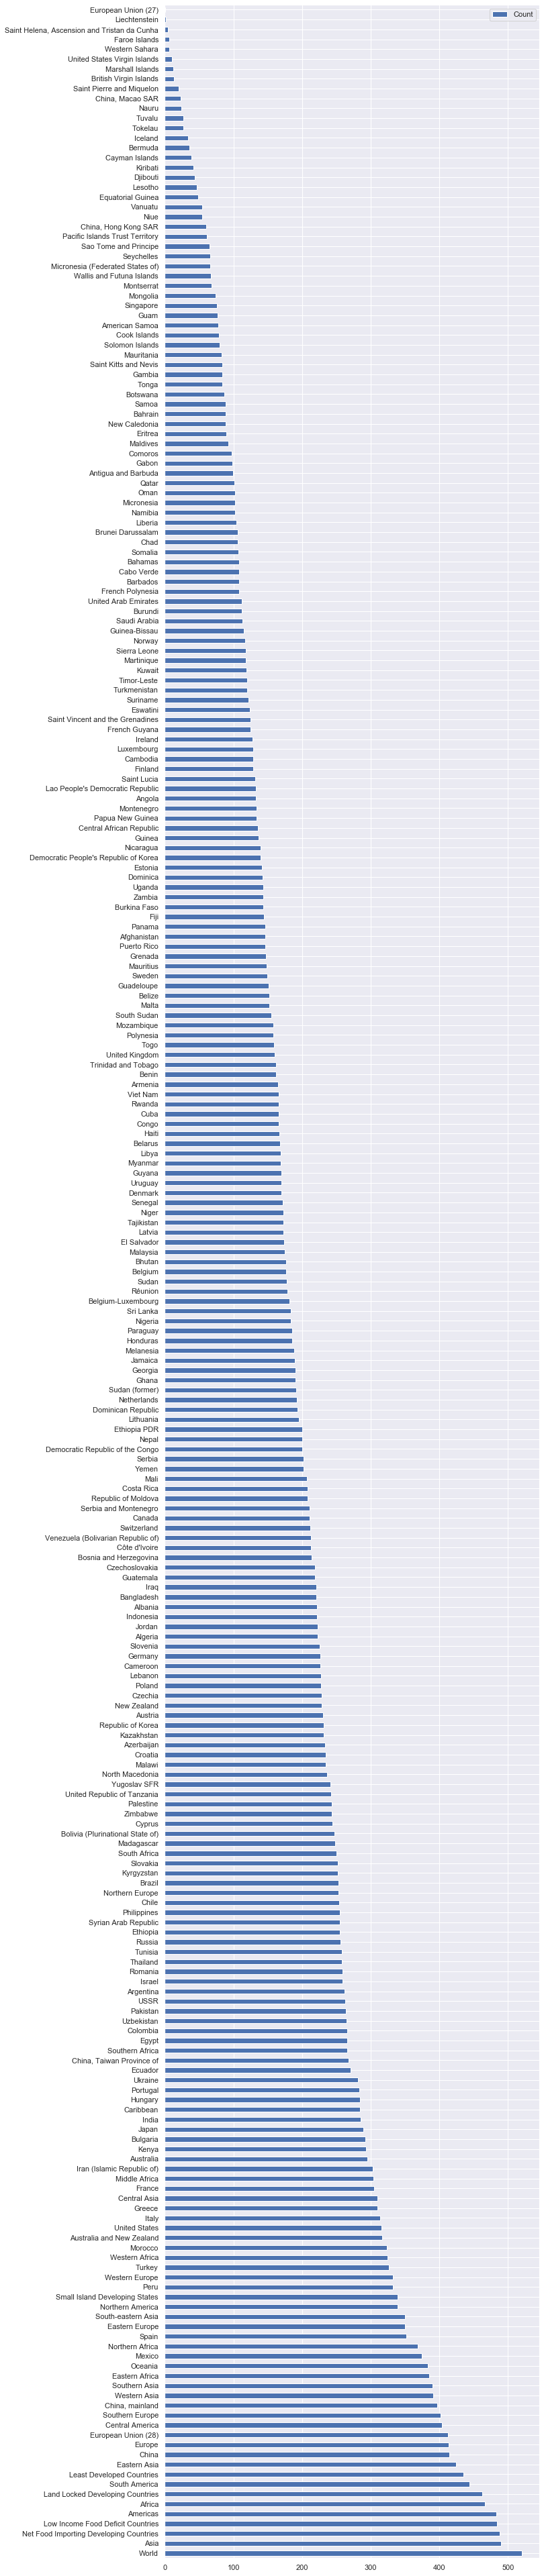

In [19]:
plt.figure(figsize=(10,20))
# sns.boxplot(raw['Area'].value_counts())

locationCounts = pd.DataFrame(raw['Area'].value_counts())
locationCounts.columns = ['Count']
locationCounts.reset_index()
locationCounts.plot.barh(figsize=(10,70))
# sns.boxplot(x=locationCounts.index, y='Count', width=0.15, data=locationCounts)    

Area  Item Code           Item  Year   Price  \
5557        Russian Federation        667            Tea  2017 1.00000   
5558        Russian Federation        667            Tea  2018 0.93098   
5559        Russian Federation        667            Tea  2019 0.88619   
6764  United States of America        656  Coffee, green  2019 0.61012   
6762  United States of America        656  Coffee, green  2018 0.58887   
...                        ...        ...            ...   ...     ...   
2034                   Ecuador        656  Coffee, green  1996 0.00027   
2029                   Ecuador        656  Coffee, green  1994 0.00013   
2027                   Ecuador        656  Coffee, green  1993 0.00005   
2025                   Ecuador        656  Coffee, green  1992 0.00001   
2023                   Ecuador        656  Coffee, green  1991 0.00000   

          continent  
5557         Europe  
5558         Europe  
5559         Europe  
6764  North America  
6762  North America  
...             ...  
2034  South America  
2029  South America  
2027  South America  
2025  South America  
2023  South America  

[1908 rows x 6 columns]

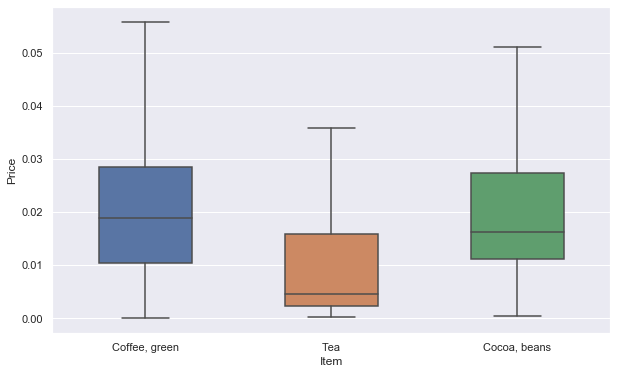

In [22]:
#distribution of prices
plt.figure(figsize=(10,6))
sns.boxplot(y='Price', x='Item',width=0.5, data=caffeinePrices, showfliers=False)
caffeinePrices.sort_values(by='Price', ascending=False)

In [21]:
#example code to remove outliers
# Q1 = df['AVG'].quantile(0.25)
# Q3 = df['AVG'].quantile(0.75)
# IQR = Q3 - Q1    #IQR is interquartile range. 

# filter = (df['AVG'] >= Q1 - 1.5 * IQR) & (df['AVG'] <= Q3 + 1.5 *IQR)
# df.loc[filter]  

In [22]:
# view of all areas..
pd.set_option('display.max_rows', 260)
areas.sort_index()

Area
Area Code                                                   
1                                                    Armenia
2                                                Afghanistan
3                                                    Albania
4                                                    Algeria
5                                             American Samoa
7                                                     Angola
8                                        Antigua and Barbuda
9                                                  Argentina
10                                                 Australia
11                                                   Austria
12                                                   Bahamas
13                                                   Bahrain
14                                                  Barbados
15                                        Belgium-Luxembourg
16                                                Bangladesh
17                                                   Bermuda
18                                                    Bhutan
19                          Bolivia (Plurinational State of)
20                                                  Botswana
21                                                    Brazil
23                                                    Belize
25                                           Solomon Islands
26                                         Brunei Darussalam
27                                                  Bulgaria
28                                                   Myanmar
29                                                   Burundi
32                                                  Cameroon
33                                                    Canada
35                                                Cabo Verde
36                                            Cayman Islands
37                                  Central African Republic
38                                                 Sri Lanka
39                                                      Chad
40                                                     Chile
41                                           China, mainland
44                                                  Colombia
45                                                   Comoros
46                                                     Congo
47                                              Cook Islands
48                                                Costa Rica
49                                                      Cuba
50                                                    Cyprus
51                                            Czechoslovakia
52                                                Azerbaijan
53                                                     Benin
54                                                   Denmark
55                                                  Dominica
56                                        Dominican Republic
57                                                   Belarus
58                                                   Ecuador
59                                                     Egypt
60                                               El Salvador
61                                         Equatorial Guinea
62                                              Ethiopia PDR
63                                                   Estonia
64                                             Faroe Islands
66                                                      Fiji
67                                                   Finland
68                                                    France
69                                             French Guyana
70                                          French Polynesia
72                                                  Djibouti
73                                                   Georgia
74                                                     Gabon
75                            

In [23]:
world = regionalDict['World']
worldProductionTotal = world[world['Element'] == 'Production'].loc[:, '1961':]
worldYieldTotal = world[world['Element'] == 'Yield'].loc[:, '1961':]
worldAreaHarvested = world[world['Element'] == 'Area harvested'].loc[:, '1961':]

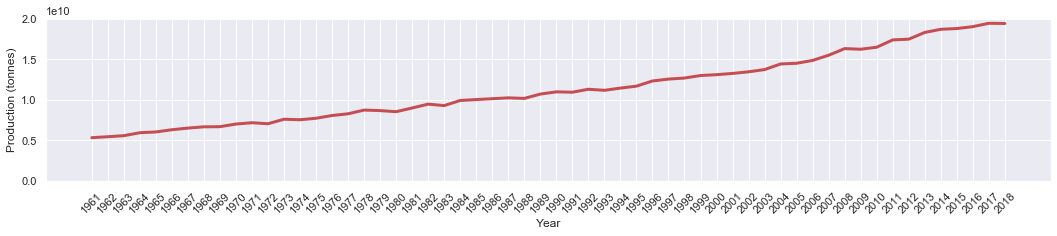

In [24]:
plt.xticks(rotation=45)
plt.plot(worldProductionTotal.sum(), label='Production', color='r', linewidth=3, markersize=12)
plt.xlabel('Year')
plt.ylabel('Production (tonnes)')
plt.ylim(0)
plt.show()

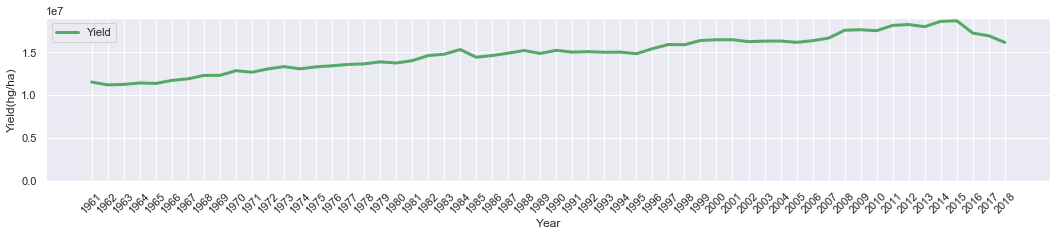

In [25]:
plt.xticks(rotation=45)
plt.plot(worldYieldTotal.sum(), label='Yield', color='g', linewidth=3, markersize=12)
plt.xlabel('Year')
plt.ylabel('Yield(hg/ha)')
plt.legend()
plt.ylim(0)
plt.show()

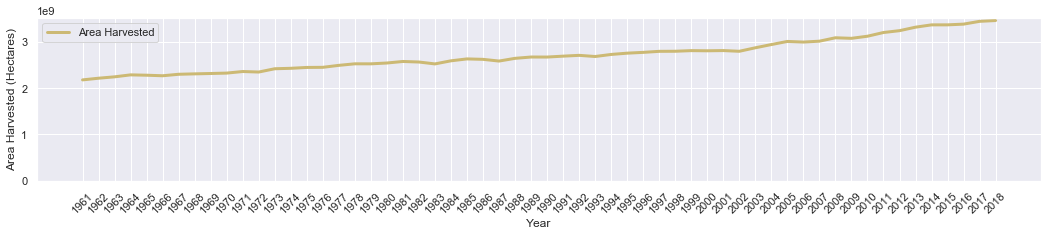

In [26]:
plt.xticks(rotation=45)
plt.plot(worldAreaHarvested.sum(), label='Area Harvested', color='y', linewidth=3, markersize=12)
plt.xlabel('Year')
plt.ylabel('Area Harvested (Hectares)')
plt.legend()
plt.ylim(0)
plt.show()

The best performing on average seems to be: Cereals, Total


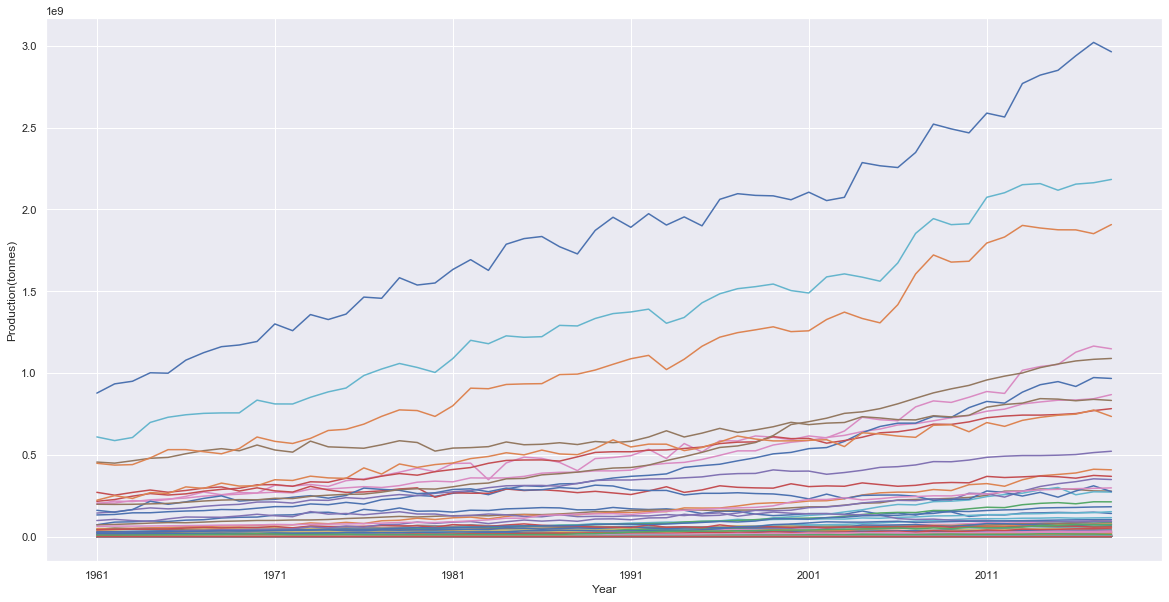

In [27]:
worldProduction = world[world['Element'] == 'Production']
worldProductionByItem = worldProduction.groupby('Item').sum().loc[:, '1961':]
# worldProductionByItem.iloc[0].plot()
for i in range(1, len(worldProductionByItem)):
    ax = worldProductionByItem.iloc[i].plot(figsize=(20, 10), label=worldProductionByItem.index[i])
    ax.set_xlabel('Year')
    ax.set_ylabel('Production(tonnes)')
print('The best performing on average seems to be: ' + worldProductionByItem.mean(axis=1).idxmax())
plt.grid(True)

## What is the correlation between climate change (surface temperatures in this case) and crop production in countries that rank in the top 3 in Climate Risk Indexes? 

These are the countries with notably high climate risk indexes and we will be observing the ones at the top.
###   
<div>
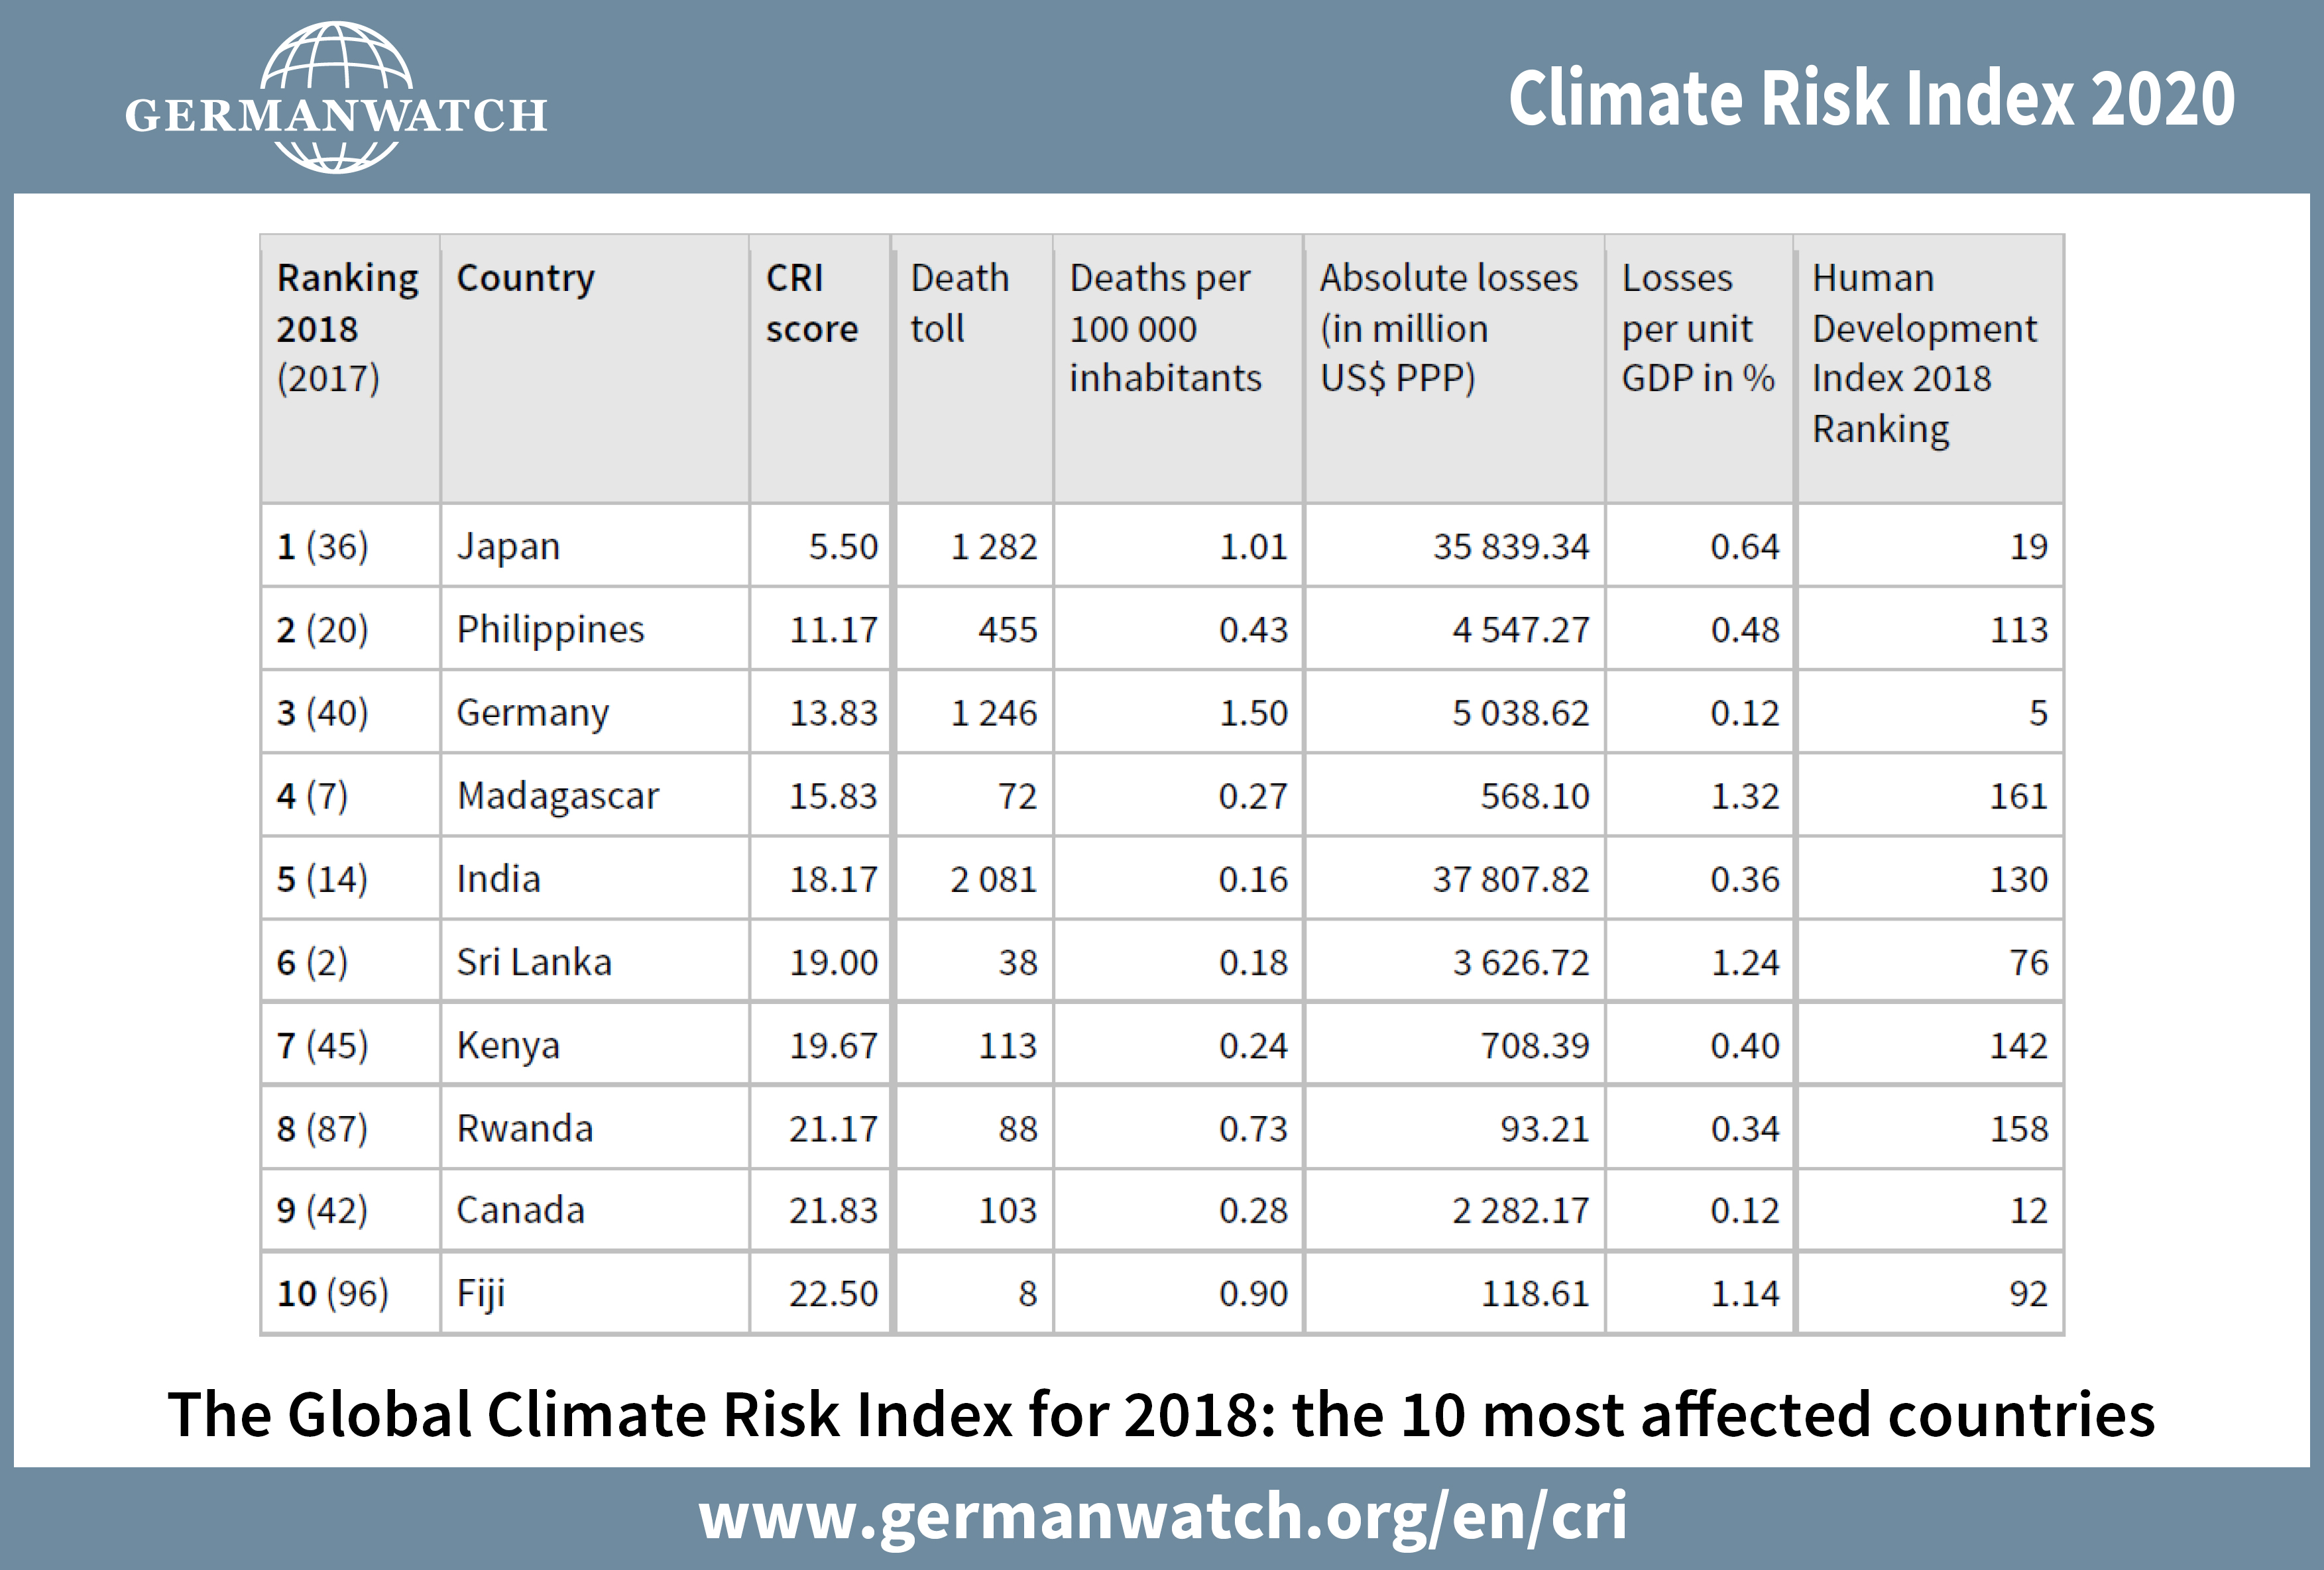
</div>

### In countries with a High Climate Risk Index, what is the correlation and does correlation actually imply causation?

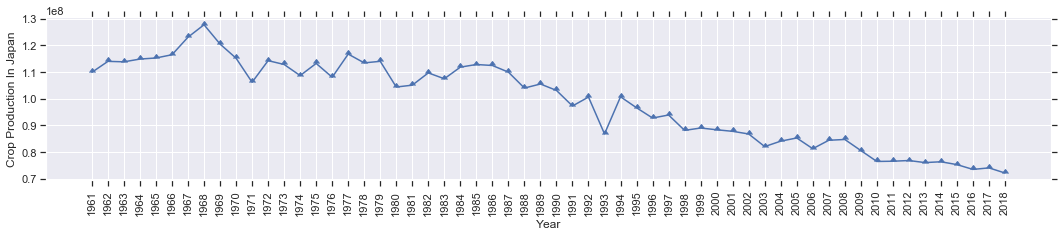

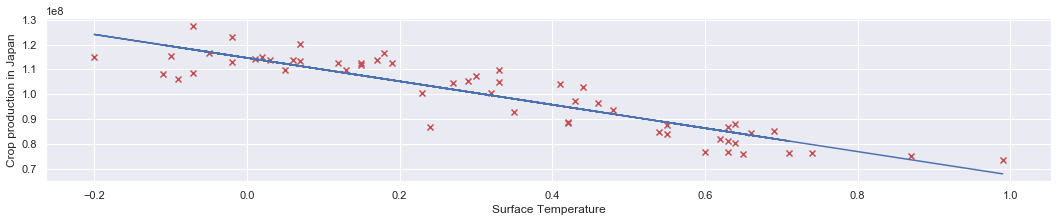

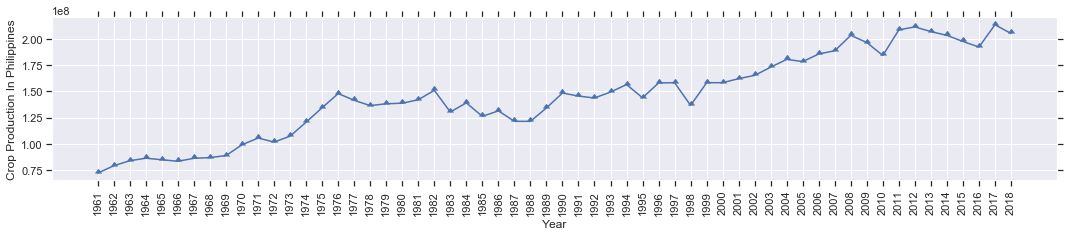

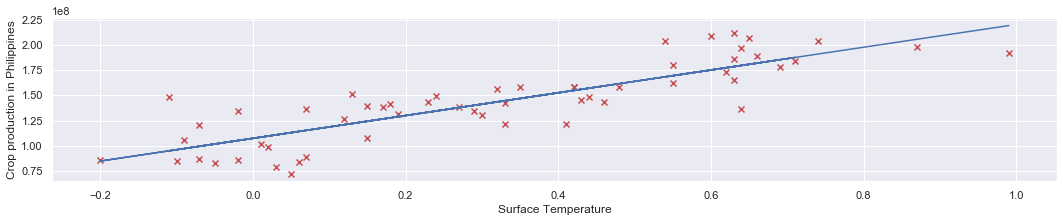

In [28]:
climate = pd.read_csv('climate/annual_csv.csv')
surfaceTemp = pd.DataFrame(climate[np.logical_and(climate['Source']=='GISTEMP', climate['Year']>=1961)].sort_values(by=['Year']))
surfaceTemp.rename({"Mean": "SurfaceTemp"}, inplace=True)
surfaceTemp['Year'] = pd.to_numeric(surfaceTemp['Year'])
surfaceTemp.drop(['Source'], axis=1, inplace=True)
surfaceTemp.set_index('Year', inplace=True)

HighCRICountries = ['Japan', 'Philippines']

for country in HighCRICountries:
    AreaAggregated = raw[raw['Area']==country]
    AreaProductionYearly = AreaAggregated[AreaAggregated['Element']=='Production'].loc[:,'1961':].sum()
    plt.plot(AreaProductionYearly, marker=10)
    plt.xlabel('Year')
    plt.ylabel('Crop Production In ' + country)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', 
    labelbottom='on')
    plt.xticks(rotation=90)
    plt.show()

    areaFormatted = pd.DataFrame()
    count = 0
    for year, value in AreaProductionYearly.iteritems():
        areaFormatted.loc[count, 'Year'] = year
        areaFormatted.loc[count, 'Total'] = value
        count += 1
    areaFormatted['Year'] = pd.to_numeric(areaFormatted['Year'])

    areaMerged = areaFormatted.merge(surfaceTemp, on='Year')
    areaMerged.set_index('Year', inplace=True)

    plt.scatter(areaMerged['Mean'], areaMerged['Total'], marker='x', cmap='viridis_r', color='r')
    plt.xlabel('Surface Temperature')
    plt.ylabel('Crop production in ' + country)

    x = np.array(areaMerged['Mean'])
    y = np.array(areaMerged['Total'])
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.show()

For Japan, the overall correlation is negative. But for other countries who have faced the impact of climate change, there is a weak to moderate positive correlation. Because of this, we can perhaps say, that the impact is not too apparent or there are other factors that need to be taken into account (industrial development, nature of crops grown, etc.), geographical position on the map and more.

# Studying Caffeine

1. What are the biggest sources of caffeine?

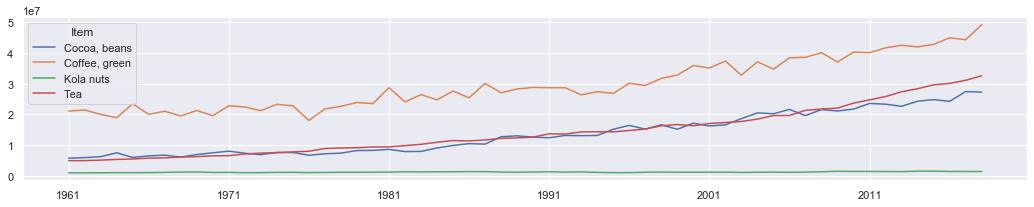

In [29]:
caffeineProduction = raw[raw['Item'].str.contains('Coffee|Tea|Cocoa|Kola')]
caffeineProduction = caffeineProduction[caffeineProduction['Element'] == 'Production']
caffeineProduction.groupby('Item').sum().loc[:,'1961':].T.plot()

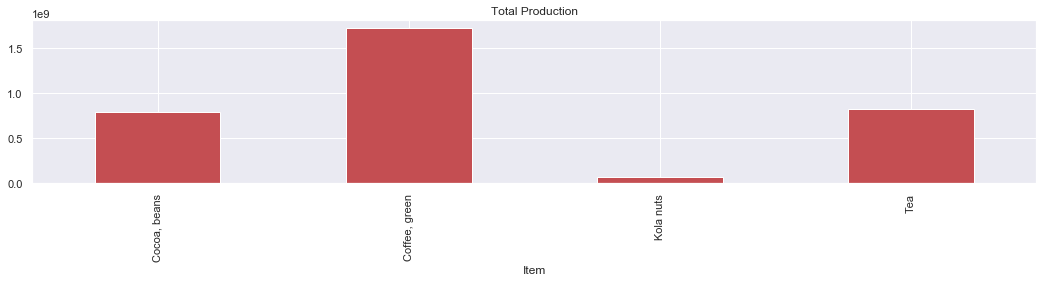

In [30]:
# Total production over the years
caffeineProduction.groupby('Item').sum().loc[:,'1961':].sum(axis=1).plot.bar(color='r')
plt.title('Total Production')
plt.show()

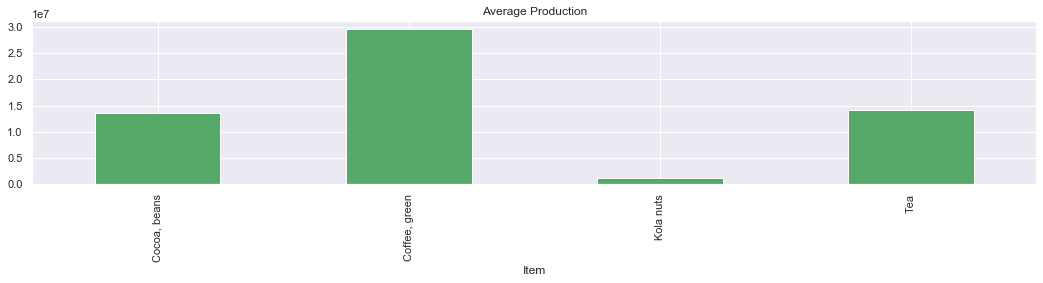

In [31]:
caffeineProduction.groupby('Item').sum().loc[:,'1961':].mean(axis=1).plot.bar(color='g')
plt.title('Average Production')
plt.show()

2. How has caffeine crop production changed over the decades, measured across Asia Pacific/Africa/Latin America and if a trend is observed for one, does that same trend apply for the others?

### Comparing sub-regionally

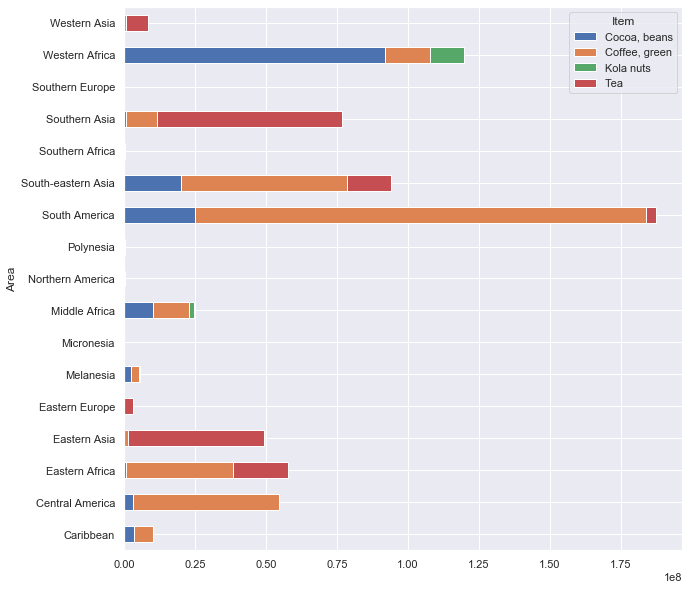

In [32]:
regionsOnly = caffeineProduction[caffeineProduction['Area'].isin(subcon_regions)]
regionsProduction = regionsOnly[regionsOnly['Element'] == 'Production']

# regionsProduction.groupby('Area').sum().mean(axis=1).plot.bar()
regionsProduction.groupby(['Area', 'Item']).sum().sum(axis=1).unstack().plot.barh(stacked=True, figsize=(10,10))

South America appears to be the biggest producer of caffeine-based crops in the world and it's biggest produce is green coffee beans, astronomically higher than any other region in the world.

### Comparing continentally

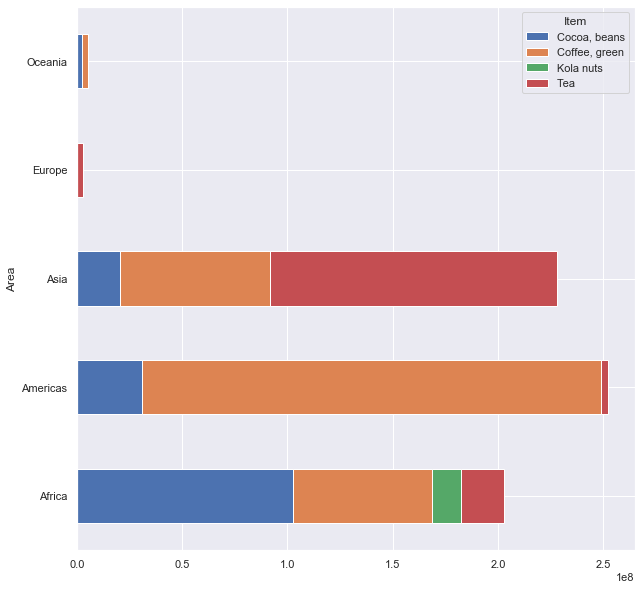

In [33]:
regionsOnly = caffeineProduction[caffeineProduction['Area'].isin(continents)]
regionsProduction = regionsOnly[regionsOnly['Element'] == 'Production']
regionsProduction.groupby(['Area', 'Item']).sum().sum(axis=1).unstack().plot.barh(stacked=True, figsize=(10,10))

Similarly, North and South America cumulatively produce the most caffeine-based crops while Asia comes close. North and South America are the biggest producers of green coffee beans, while Asia produces the most tea leaves and Africa produces the most cocoa beans. The three regions actively grow a different combination of crops and contribute differently to the global market.

## Asia, Africa, Americas (World's Biggest Manufacturers)

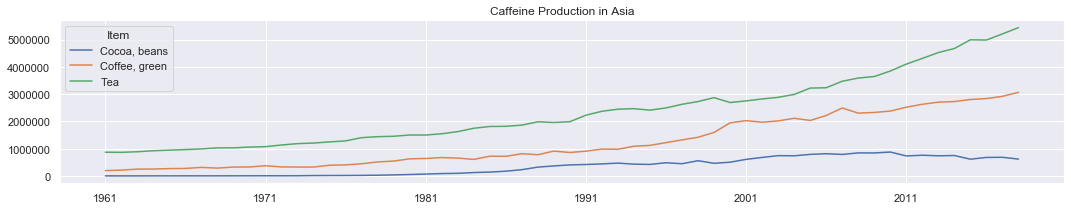

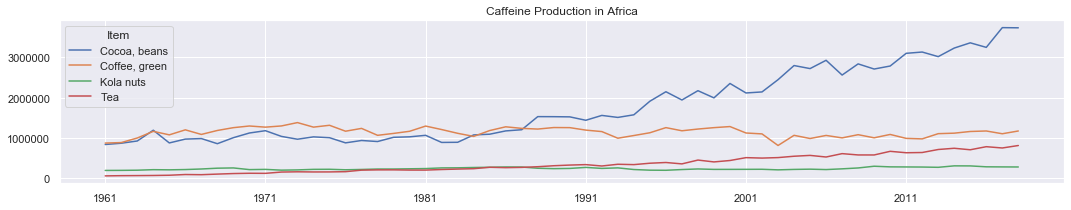

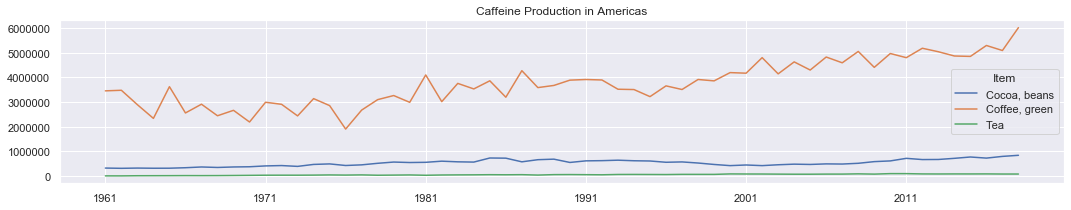

In [34]:
biggestManufacturers = ['Asia', 'Africa', 'Americas']

for continent in biggestManufacturers:
    contProduction = caffeineProduction[caffeineProduction['Area'] == continent].set_index('Item').loc[:, '1961':]
    contProduction.T.plot(title=f'Caffeine Production in {continent}')

### Understanding the trends
The takeaways from the depictions:

1) Global Production of Caffeine based crops is on an overall upward trend, even if there are mild fluctuations over the years. This can be attributed to either an increasing population, increasing demand, further cultivation of these crops, higher export rates, etc.

2) The 3 biggest sources of caffeine are cocoa beans, green coffee beans and tea leaves and each of the regions are leaders in each of these. Asia sort of ```specialises```in tea leaves, Africa in cocoa and the Americas in green coffee beans.

3) In proportion, coffee beans production in the Americas is not very stable, with sudden spikes and extreme fluctuations, the pattern being much more noticeable than the other 2 continents.

4) Asia's growth, at first sight, is the smoothest.

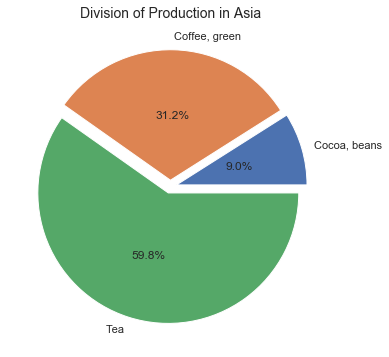

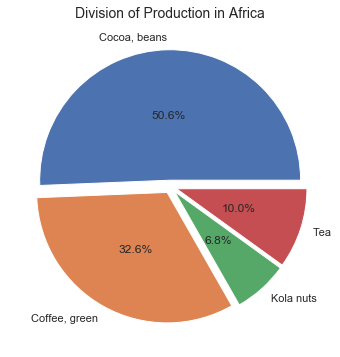

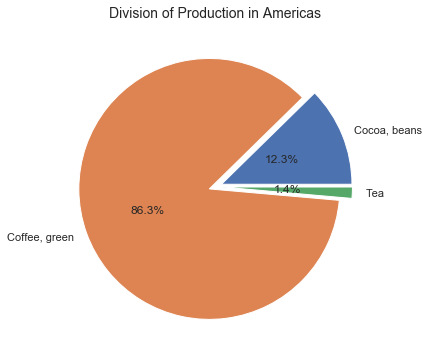

In [35]:
biggestManufacturers = ['Asia', 'Africa', 'Americas']

for continent in biggestManufacturers:
    contProduction = caffeineProduction[caffeineProduction['Area'] == continent].set_index('Item').loc[:, '1961':]
    contTotals = contProduction.sum(axis=1)
    pie, ax = plt.subplots(figsize=[10,6])
    labels = contTotals.keys()
    plt.pie(x=contTotals, autopct="%.1f%%", explode=[0.05]*len(labels), labels=labels, pctdistance=0.5)
    plt.title(f"Division of Production in {continent}", fontsize=14);

While pie charts aren't a good indication of volume, it does say something about how the market share is split and it reaffirms the points made above.

----------------------------------------------------------------------------------------------------------------------

3. How has the price of caffeine crops changed over the years in these chosen economies and is that attributed to any particular factor (a sudden introduction of an alternative, etc.)? Is there an effect of production levels on the prices of caffeine-based crops (helps to weigh their value)? When production increases or decreases, what generally happens?

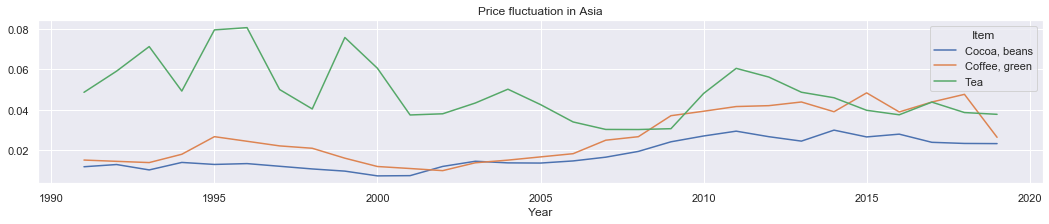

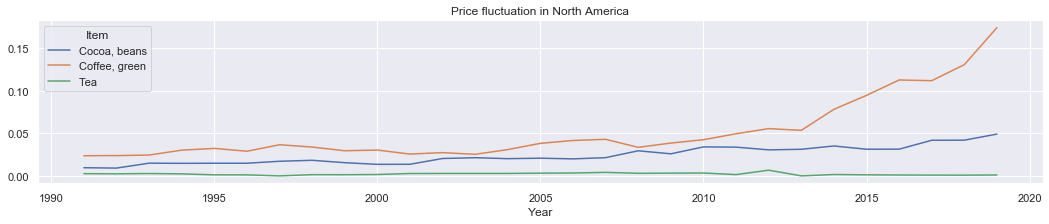

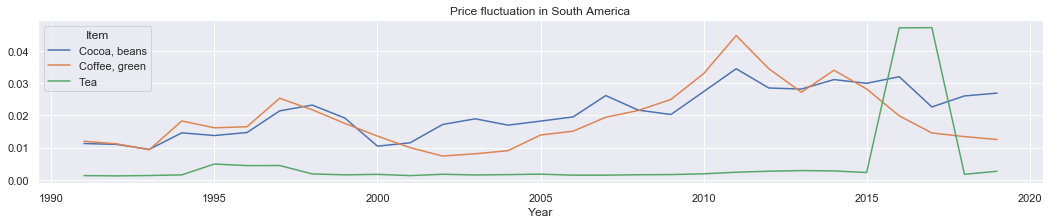

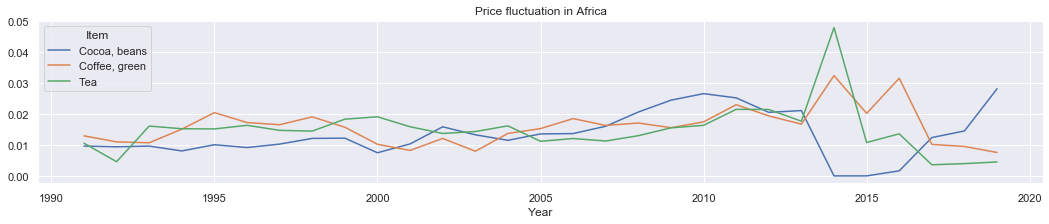

In [36]:
biggestManufacturers = ['Asia', 'North America', 'South America', 'Africa']
caffeinePrices.fillna(0, inplace=True)
for continent in biggestManufacturers:
    caffeinePriceRange = caffeinePrices[caffeinePrices['continent'] == continent].set_index('Year')
    continentGrouped = caffeinePriceRange.groupby(['Year','Item'])['Price'].mean().unstack()
    continentGrouped.fillna(0, inplace=True)
    continentGrouped.plot(title=f'Price fluctuation in {continent}')

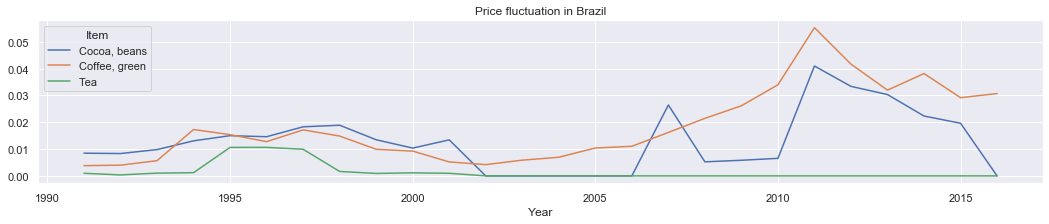

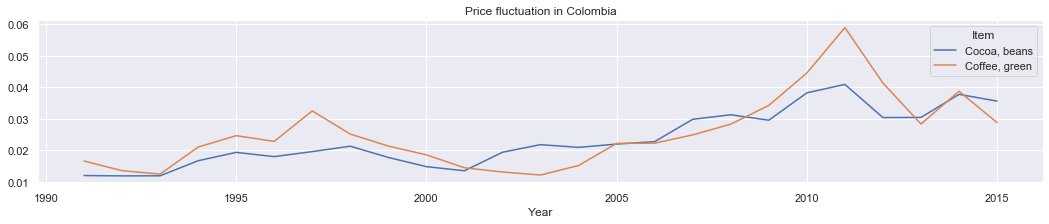

In [37]:
countries = ['Brazil', 'Colombia']
# print(caffeinePrices['Area'].value_counts())
for country in countries:
    caffeinePriceRange = caffeinePrices[caffeinePrices['Area'] == country].set_index('Year')
    countryGrouped = caffeinePriceRange.groupby(['Year','Item'])['Price'].mean().unstack()
    countryGrouped.fillna(0, inplace=True)
    countryGrouped.plot(title=f'Price fluctuation in {country}')

In [38]:
caffeineSorted = caffeineProduction.groupby(['Item']).mean().T.reset_index()
priceMerge = caffeinePrices.drop(['continent', 'Item Code', 'Area'], axis=1)

caffeineSorted.columns = ['Year', 'Cocoa, beans', 'Coffee, green', 'Kola nuts', 'Tea']
caffeineSorted['Year']
caffeineSorted = pd.melt(caffeineSorted, id_vars=['Year'], value_vars=caffeineSorted.columns[1:], var_name='Item', value_name='Production')
caffeineSorted.Year = caffeineSorted.Year.astype(str)
priceMerge.Year = priceMerge.Year.astype(str)
merged = caffeineSorted.merge(priceMerge, on=['Year', 'Item'])

merged.set_index('Year')
# sns.regplot(x='Production', y='Value',data=merged)

Item   Production   Price
Year                                   
1991  Cocoa, beans 141940.19540 0.01127
1991  Cocoa, beans 141940.19540 0.00847
1991  Cocoa, beans 141940.19540 0.00970
1991  Cocoa, beans 141940.19540 0.01192
1991  Cocoa, beans 141940.19540 0.00423
...            ...          ...     ...
2018           Tea 423099.68831 0.93098
2018           Tea 423099.68831 0.00263
2018           Tea 423099.68831 0.00756
2018           Tea 423099.68831 0.00655
2018           Tea 423099.68831 0.00513

[1871 rows x 3 columns]

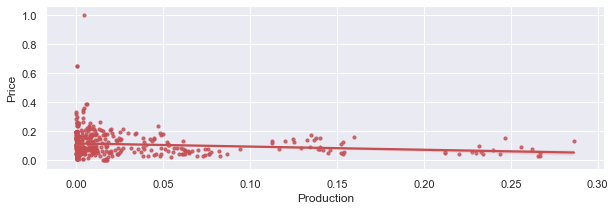

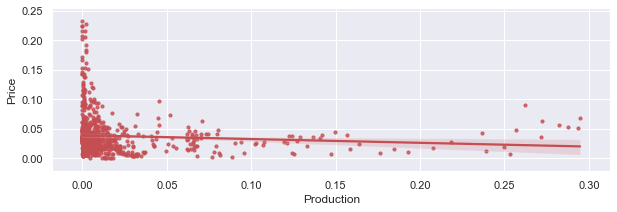

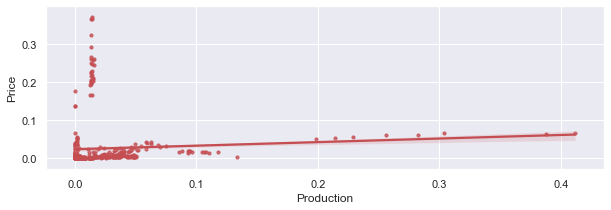

In [39]:
#Looking at coffee, green beans
def prodPriceCorr(item):
    greencoffeeprices = caffeinePrices.copy()[caffeinePrices['Item'] == item]
    greencoffeeproduction = caffeineProduction[caffeineProduction['Item'] == item]
    greencoffeeproduction = greencoffeeproduction.melt(id_vars=['Area'], value_vars=greencoffeeproduction.columns[3:],
                              var_name='Year', value_name='Production')
    greencoffeeprices.drop(columns=['Item', 'Item Code', 'continent'], inplace=True)
    greencoffeeprices['Year'] = greencoffeeprices['Year'].astype(str)
    greencoffeeproduction['Year'] = greencoffeeproduction['Year'].astype(str)
    
    greencoffeeproduction[['Production']] = greencoffeeproduction[['Production']].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
    greencoffeeprices[['Price']] = greencoffeeprices[['Price']].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

    merged = greencoffeeproduction.merge(greencoffeeprices, on=['Area', 'Year'])
    merged.sort_values(by='Production')

    plt.figure(figsize=(10,3))
    sns.regplot(x='Production', y='Price', data=merged, color='r',scatter_kws={"s": 10})
    
caffeineItems = ['Cocoa, beans', 'Coffee, green', 'Tea']
for item in caffeineItems:
    prodPriceCorr(item)
    
    

4. In 1971 and other key dates in the growth of Starbucks, an international coffee beverage company. Were there any noticeable trends in global or regional coffee production near this time period?

In [40]:
caffeineYield = raw[raw['Item'].str.contains('Coffee|Tea|Cocoa|Kola')]
caffeineYield = caffeineYield[caffeineYield['Element'] == 'Yield']

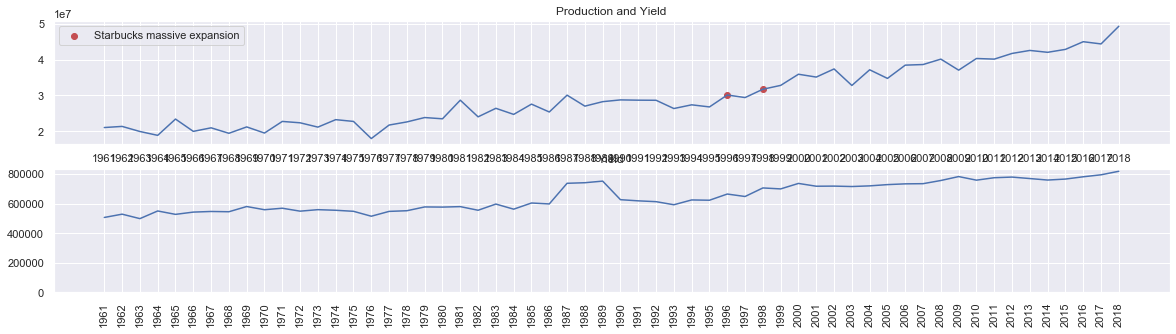

In [41]:
totalProd = caffeineProduction[caffeineProduction['Item'].str.contains('Coffee')].groupby('Item').sum().loc[:,'1961':].sum()
totalYield = caffeineYield[caffeineYield['Item'].str.contains('Coffee')].groupby('Item').sum().loc[:,'1961':].sum()
# plot.set_ylim(ymin=0)

fig, axes = plt.subplots(2, 1, figsize=(20, 5))
plt.xticks(rotation=90)
axes[0].plot(totalProd)
axes[0].set_title('Production and Yield')
axes[1].plot(totalYield)
axes[1].set_title('Yield')
# plt.xticks(rotation=90)
plt.ylim(0)
axes[0].scatter(['1996', '1998'], [totalProd['1996'], totalProd['1998']], marker='o', color='r', label='Starbucks massive expansion')
axes[0].legend(loc='upper left')

From the starbucks website:
```    1998
    Extends the Starbucks brand into grocery channels across the U.S.
    Opens in underserved neighborhoods through joint-venture partnership with Magic Johnson.
    Launches Starbucks.com.
    Establishes the CUP Fund emergency financial assistance fund for partners.
    Opens stores in: England, Malaysia, New Zealand, Taiwan and Thailand.
    Total stores: 1,886
```
So this happened in 2003, hence the drop there. 
https://www.nytimes.com/2003/11/25/business/difficult-times-for-coffee-industry.html

In recent years, the climb has been phenomenal, which means that it is rather promising. Other economic sources also confirm this.

## Data Modeling

The factors that impact crop growth are mainly rainfall and temperature. We have this data, so is it possible to train a regression model for future predictions? Let's see.

## Worldwide Correlation (just as an experiment)

In [46]:
rainfallAndTemperatures.reset_index(inplace=True)
rainfallAndTemperatures.rename(columns={"Country": "Area"},inplace=True)
rawMelted = raw[raw['Element'] == 'Production'].melt(id_vars=['Area'], value_vars=raw.columns[3:],
                              var_name='Year', value_name='Production')
rawMeltedProduction = rawMelted.groupby(['Year','Area'])['Production'].sum().reset_index()
# rawMeltedProduction['Year'] = rawMeltedProduction['Year'].astype(str)
rawMeltedProduction['Area'] = rawMeltedProduction['Area'].astype(str)
rainfallAndTemperatures['Year'] = rainfallAndTemperatures['Year'].astype(str)
rainfallAndTemperatures['Area'] = rainfallAndTemperatures['Area'].astype(str)
rainfallAndTemperatures['Area'] = rainfallAndTemperatures['Area'].str.strip()
rawMeltedProduction['Area'] = rawMeltedProduction['Area'].str.strip()
productionRainfallTemp = pd.merge(rawMeltedProduction, rainfallAndTemperatures, on=["Year", "Area"], how='inner')
# productionRainfallTemp.drop(columns=['index'], inplace=True)

In [47]:
rainfallAndTemperatures

Year         Area  Rainfall - (MM)  Temperature - (Celsius)
0     1991  Afghanistan        435.44990                 12.89449
1     1991      Albania        917.86880                 11.03765
2     1991      Algeria         88.13276                 22.51346
3     1991      Andorra        757.11630                 11.18815
4     1991       Angola       1017.98660                 21.71688
...    ...          ...              ...                      ...
5065  2016    Venezuela       1844.70330                 26.47820
5066  2016      Vietnam       1988.86180                 25.07316
5067  2016        Yemen        171.48137                 24.22120
5068  2016       Zambia        803.47810                 22.73705
5069  2016     Zimbabwe        455.13295                 22.31017

[5070 rows x 4 columns]

In [48]:
if('index' in productionRainfallTemp.columns):
    productionRainfallTemp.drop(columns=['index'], inplace=True)
if('level_0' in productionRainfallTemp.columns):
    productionRainfallTemp.drop(columns=['level_0'], inplace=True)

[Text(0, 0.5, 'Production'),
 Text(0, 1.5, 'Rainfall - (MM)'),
 Text(0, 2.5, 'Temperature - (Celsius)')]

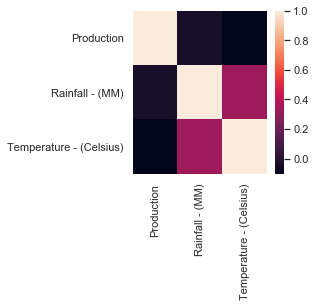

In [49]:
plt.figure(figsize=(3,3))
productionRainfallWorld = sns.heatmap(productionRainfallTemp.corr())
productionRainfallWorld.set_yticklabels(productionRainfallWorld.get_xticklabels(), rotation=0) 

In [50]:
rainfallAndTemperatures.reset_index(inplace=True)
rainfallAndTemperatures.rename(columns={"Country": "Area"},inplace=True)
rawMeltedYield = raw[raw['Element'] == 'Yield'].melt(id_vars=['Area'], value_vars=raw.columns[3:],
                              var_name='Year', value_name='Yield')
rawMeltedYield = rawMeltedYield.groupby(['Year','Area'])['Yield'].mean().reset_index()
rawMeltedYield['Year'] = rawMeltedYield['Year'].astype(str)
rawMeltedYield['Area'] = rawMeltedYield['Area'].astype(str)
rainfallAndTemperatures['Year'] = rainfallAndTemperatures['Year'].astype(str)
rainfallAndTemperatures['Area'] = rainfallAndTemperatures['Area'].astype(str)
rainfallAndTemperatures['Area'] = rainfallAndTemperatures['Area'].str.strip()
rawMeltedYield['Area'] = rawMeltedYield['Area'].str.strip()
productionRainfallTempYield = pd.merge(rawMeltedYield, rainfallAndTemperatures, on=["Year", "Area"], how='inner')

In [51]:
if('index' in productionRainfallTempYield.columns):
    productionRainfallTempYield.drop(columns=['index'], inplace=True)
if('level_0' in productionRainfallTempYield.columns):
    productionRainfallTempYield.drop(columns=['level_0'], inplace=True)

Yield  Rainfall - (MM)  Temperature - (Celsius)
Yield                    1.00000         -0.07572                 -0.28008
Rainfall - (MM)         -0.07572          1.00000                  0.34299
Temperature - (Celsius) -0.28008          0.34299                  1.00000

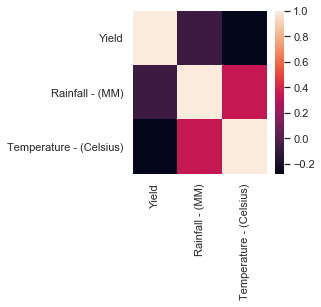

In [52]:
plt.figure(figsize=(3,3))
sns.heatmap(productionRainfallTempYield.corr())
productionRainfallTempYield.corr()

## Per Country Correlations

### Crops Overall

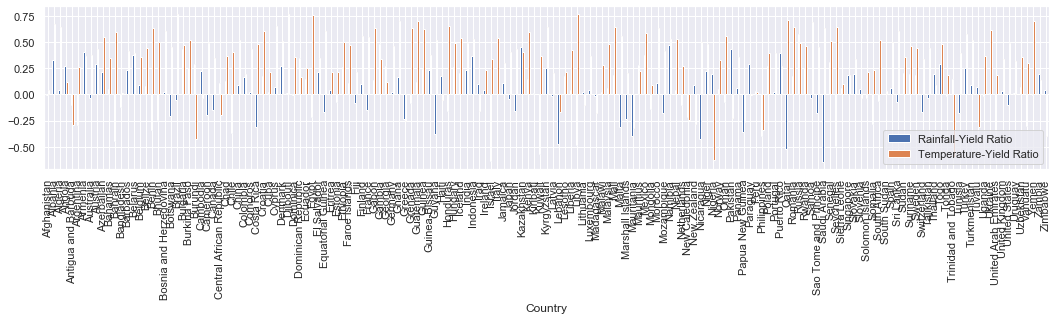

In [53]:
countriesOfInterest = rawMeltedYield['Area'].unique()
countriesMeetingThreshold = []
tempCorr = pd.DataFrame()

for country in countriesOfInterest:
    countryyield = rawMeltedYield[rawMeltedYield['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged.drop(columns=['index'], inplace=True)
    corr = countrymerged.corr()
#     corr.drop(columns=['index'], inplace=True)
    tempCorr = corr
    countriesMeetingThreshold.append([country, corr.iloc[1,0], corr.iloc[2,0]])    

countriesMeetingThreshold = pd.DataFrame(countriesMeetingThreshold, columns=['Country', 'Rainfall-Yield Ratio', 'Temperature-Yield Ratio'])
countriesMeetingThreshold.dropna(inplace=True)
countriesMeetingThreshold.sort_values(by='Temperature-Yield Ratio', ascending=False)
countriesMeetingThreshold.set_index('Country', inplace=True)
countriesMeetingThreshold.plot.bar()

In [54]:
countriesMeetingThreshold.sort_values(by=['Rainfall-Yield Ratio', 'Temperature-Yield Ratio'], ascending=False)

Rainfall-Yield Ratio  Temperature-Yield Ratio
Country                                                                
Russia                                 0.57755                  0.49592
Gambia                                 0.48618                  0.34012
Namibia                                0.47276                  0.53165
Kazakhstan                             0.45421                  0.41131
Bulgaria                               0.44078                  0.47669
Pakistan                               0.43911                 -0.22361
Armenia                                0.40261                  0.36479
Puerto Rico                            0.39602                  0.27569
Belarus                                0.38300                  0.39582
Mexico                                 0.37934                  0.58979
Indonesia                              0.36565                  0.53219
Dominican Republic                     0.34793                  0.16762
Albania                                0.32665                  0.67317
Senegal                                0.31418                  0.50832
Burundi                                0.29702                 -0.42296
Togo                                   0.29534                  0.47984
Paraguay                               0.29344                 -0.00406
Austria                                0.29225                  0.43360
Mauritius                              0.28600                  0.22314
Angola                                 0.27512                  0.11604
Georgia                                0.27425                  0.11573
Poland                                 0.27363                  0.40235
Denmark                                0.27107                  0.51238
Hungary                                0.26325                  0.49657
Ethiopia                               0.25969                  0.50646
Rwanda                                 0.25573                  0.46748
Burkina Faso                           0.25406                  0.52475
Kyrgyzstan                             0.25349                  0.64344
Turkey                                 0.25136                  0.58417
Guinea                                 0.24802                  0.62378
India                                  0.23811                  0.49564
Barbados                               0.23752                  0.41223
Guinea-Bissau                          0.23043                  0.37978
Cambodia                               0.22475                 -0.03174
Niger                                  0.22168                  0.48720
Azerbaijan                             0.21651                  0.54784
El Salvador                            0.21468                  0.35064
Sudan                                  0.20700                  0.36004
Iceland                                0.20156                  0.54075
Zambia                                 0.20095                  0.13561
Nigeria                                0.19978                 -0.62872
Suriname                               0.19790                  0.46060
Thailand                               0.19682                  0.09416
Slovakia                               0.19175                  0.33605
Sweden                                 0.18904                  0.44852
Mali                                   0.18405                  0.64274
Singapore                              0.18390                  0.19109
Lesotho                                0.18019                  0.21424
Croatia                                0.17873                  0.61120
Romania                                0.17832                  0.64965
Haiti                                  0.17785                 -0.05283
Colombia                               0.16621                  0.19478
Ghana                                  0.16607                  0.70505
Trinidad and Tobago                    0.15164                 -0.

### Only Caffeine-Based Crops

In [55]:
caffeineMelted = raw[np.logical_and(raw['Element'] == 'Yield', raw['Item'].str.contains('Coffee|Tea|Kola'))].melt(id_vars=['Area'], value_vars=raw.columns[3:],
                              var_name='Year', value_name='Production')

In [56]:
caffeineMelted.sort_values(by='Production', ascending=False)

Area  Year   Production
5426                    Mauritius  1988 133333.00000
5228                    Mauritius  1987 133333.00000
5624                    Mauritius  1989 125000.00000
10756  Iran (Islamic Republic of)  2015 105777.00000
7192   Iran (Islamic Republic of)  1997  89276.00000
...                           ...   ...          ...
1042                        Ghana  1966      0.00000
4518              Central America  1983      0.00000
1798                     Cameroon  1970      0.00000
1040                      Georgia  1966      0.00000
2214                     Dominica  1972      0.00000

[11484 rows x 3 columns]

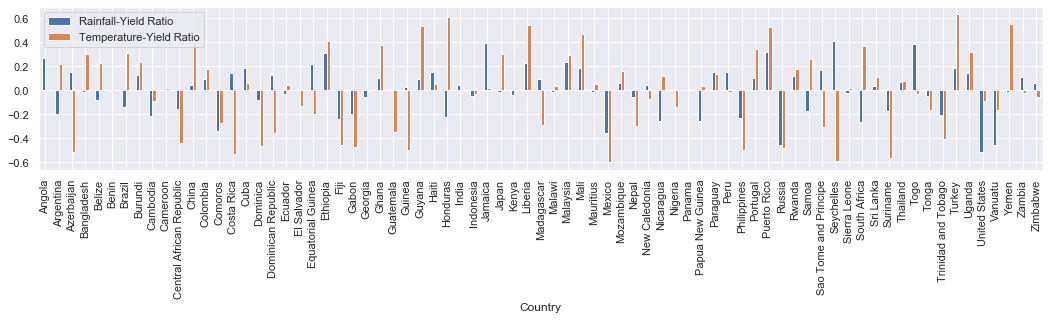

In [57]:
countriesOfInterest = caffeineMelted['Area'].unique()
countriesMeetingThreshold = []
tempCorr = pd.DataFrame()

for country in countriesOfInterest:
    countryyield = caffeineMelted[caffeineMelted['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged.drop(columns=['index'], inplace=True)
    corr = countrymerged.corr()
    tempCorr = corr
    countriesMeetingThreshold.append([country, corr.iloc[1,0], corr.iloc[2,0]])    

countriesMeetingThreshold = pd.DataFrame(countriesMeetingThreshold, columns=['Country', 'Rainfall-Yield Ratio', 'Temperature-Yield Ratio'])
countriesMeetingThreshold.dropna(inplace=True)
countriesMeetingThreshold.sort_values(by='Temperature-Yield Ratio', ascending=False)
countriesMeetingThreshold.set_index('Country', inplace=True)
countriesMeetingThreshold.plot.bar()

In [58]:
countriesMeetingThreshold

Rainfall-Yield Ratio  Temperature-Yield Ratio
Country                                                                
Angola                                 0.27125                  0.00231
Argentina                             -0.19656                  0.21809
Azerbaijan                             0.15343                 -0.51647
Bangladesh                            -0.01644                  0.30479
Belize                                -0.07813                  0.22611
Benin                                 -0.00873                  0.00096
Brazil                                -0.14140                  0.31226
Burundi                                0.12597                  0.23418
Cambodia                              -0.21825                 -0.09161
Cameroon                              -0.00109                  0.01993
Central African Republic              -0.16002                 -0.43685
China                                  0.04222                  0.39540
Colombia                               0.09259                  0.17873
Comoros                               -0.33641                 -0.27457
Costa Rica                             0.14256                 -0.52694
Cuba                                   0.18833                  0.05804
Dominica                              -0.08474                 -0.46468
Dominican Republic                     0.12446                 -0.35351
Ecuador                               -0.03320                  0.04134
El Salvador                            0.00931                 -0.12800
Equatorial Guinea                      0.22067                 -0.20015
Ethiopia                               0.30871                  0.40905
Fiji                                  -0.24278                 -0.45367
Gabon                                 -0.19758                 -0.46907
Georgia                               -0.05956                 -0.00825
Ghana                                  0.10476                  0.37685
Guatemala                              0.00660                 -0.35149
Guinea                                 0.03065                 -0.49945
Guyana                                 0.09369                  0.53216
Haiti                                  0.14858                  0.05403
Honduras                              -0.22056                  0.61272
India                                  0.04372                  0.00440
Indonesia                             -0.04488                 -0.03466
Jamaica                                0.39376                  0.01494
Japan                                 -0.01520                  0.29965
Kenya                                 -0.03610                 -0.00997
Liberia                                0.22390                  0.54352
Madagascar                             0.09411                 -0.28976
Malawi                                -0.01113                  0.03282
Malaysia                               0.23481                  0.28902
Mali                                   0.18875                  0.46452
Mauritius                             -0.01227                  0.05089
Mexico                                -0.35643                 -0.60151
Mozambique                             0.05927                  0.16204
Nepal                                 -0.05740                 -0.29451
New Caledonia                          0.03932                 -0.07321
Nicaragua                             -0.25765                  0.11504
Nigeria                                0.01035                 -0.14216
Panama                                 0.00025                  0.01404
Papua New Guinea                      -0.25327                  0.03749
Paraguay                               0.14875                  0.13653
Peru                                   0.15140                 -0.01383
Philippines                           -0.22951                 -0.49731
Portugal                               0.10099                  0.

## Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [73]:
for country in ['Namibia', 'Russia', 'Gambia']:
    countryyield = rawMeltedYield[rawMeltedYield['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged.drop(columns=['index'], inplace=True)

    #normalize rainfall and temperature
    min_max_scaler = preprocessing.MinMaxScaler()
    column_names_to_normalize = ['Yield', 'Rainfall - (MM)', 'Temperature - (Celsius)']
    x = countrymerged[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = countrymerged.index)
    countrymerged[column_names_to_normalize] = df_temp

    countrymerged['Year'] = countrymerged['Year'].astype(int)
    countrymerged['Year']
    y = countrymerged['Yield'].values
    X = countrymerged.drop(['Year', 'Area', 'Yield'], axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    reg_test = LinearRegression()
    reg_test.fit(X_train, y_train)

    y_pred = reg_test.predict(X_test)
    
#     reg_test.plot()
    # Compute and print R^2 and RMSE
    print("R^2: {} for {}".format(reg_test.score(X_test, y_test), country))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error: {} for {}".format(rmse, country))

AttributeError: 'LinearRegression' object has no attribute 'plot'

In [64]:
countrymerged

Year     Area   Yield  Rainfall - (MM)  Temperature - (Celsius)
0   1991  Namibia 0.01978          0.53378                  0.08973
1   1992  Namibia 0.00000          0.00000                  0.36151
2   1993  Namibia 0.00587          0.45785                  0.40627
3   1994  Namibia 0.01990          0.28906                  0.20338
4   1995  Namibia 0.02384          0.08011                  0.39540
5   1996  Namibia 0.03222          0.20733                  0.00000
6   1997  Namibia 0.22253          0.56397                  0.29035
7   1998  Namibia 0.22493          0.10963                  0.49012
8   1999  Namibia 0.22069          0.41065                  0.47981
9   2000  Namibia 0.90375          0.55857                  0.23561
10  2001  Namibia 0.90783          0.46030                  0.32461
11  2002  Namibia 0.90487          0.48047                  0.35658
12  2003  Namibia 0.93851          0.41491                  0.58459
13  2004  Namibia 0.96762          0.48275                  0.59247
14  2005  Namibia 1.00000          0.37824                  0.65415
15  2006  Namibia 0.94872          1.00000                  0.30283
16  2007  Namibia 0.95978          0.42162                  0.37043
17  2008  Namibia 0.91288          0.40858                  0.33528
18  2009  Namibia 0.91725          0.66727                  0.81535
19  2010  Namibia 0.91563          0.42487                  0.71029
20  2011  Namibia 0.92855          0.80669                  0.38998
21  2012  Namibia 0.93572          0.54928                  0.54475
22  2013  Namibia 0.92700          0.25474                  0.61403
23  2014  Namibia 0.91573          0.62764                  0.67998
24  2015  Namibia 0.92373          0.22996                  1.00000
25  2016  Namibia 0.91489          0.35447                  0.97291

LinearRegression()

R^2: 0.4291310698733717
Root Mean Squared Error: 0.3153798982452857


In [67]:
y_pred

array([0.61420909, 0.51759477, 0.34069854, 0.96500716, 0.55396022,
       0.50290368, 0.7842668 , 0.15233984])

In [68]:
y_test

array([0.22069225, 0.95977655, 0.01978234, 0.92372639, 0.90487145,
       0.90375057, 0.96762425, 0.        ])

In [ ]:
X_test

In [69]:
rawMeltedYield[rawMeltedYield['Area'] == 'Russia']

Year    Area       Yield
186    1961  Russia     0.00000
442    1962  Russia     0.00000
698    1963  Russia     0.00000
954    1964  Russia     0.00000
1210   1965  Russia     0.00000
1466   1966  Russia     0.00000
1722   1967  Russia     0.00000
1978   1968  Russia     0.00000
2234   1969  Russia     0.00000
2490   1970  Russia     0.00000
2746   1971  Russia     0.00000
3002   1972  Russia     0.00000
3258   1973  Russia     0.00000
3514   1974  Russia     0.00000
3770   1975  Russia     0.00000
4026   1976  Russia     0.00000
4282   1977  Russia     0.00000
4538   1978  Russia     0.00000
4794   1979  Russia     0.00000
5050   1980  Russia     0.00000
5306   1981  Russia     0.00000
5562   1982  Russia     0.00000
5818   1983  Russia     0.00000
6074   1984  Russia     0.00000
6330   1985  Russia     0.00000
6586   1986  Russia     0.00000
6842   1987  Russia     0.00000
7098   1988  Russia     0.00000
7354   1989  Russia     0.00000
7610   1990  Russia     0.00000
7866   1991  Russia     0.00000
8122   1992  Russia 40208.48750
8378   1993  Russia 39671.77500
8634   1994  Russia 34472.28750
8890   1995  Russia 38881.78750
9146   1996  Russia 39948.32500
9402   1997  Russia 41713.63750
9658   1998  Russia 38235.60000
9914   1999  Russia 39221.15000
10170  2000  Russia 39650.73750
10426  2001  Russia 39967.07500
10682  2002  Russia 41382.80000
10938  2003  Russia 43757.62500
11194  2004  Russia 46869.66250
11450  2005  Russia 49186.51250
11706  2006  Russia 52712.38750
11962  2007  Russia 52016.50000
12218  2008  Russia 56888.36250
12474  2009  Russia 57639.72500
12730  2010  Russia 49728.32500
12986  2011  Russia 61080.00000
13242  2012  Russia 61252.53750
13498  2013  Russia 64303.15000
13754  2014  Russia 63283.40000
14010  2015  Russia 64802.16250
14266  2016  Russia 69111.27500
14522  2017  Russia 71420.92500
14778  2018  Russia 70872.92500